<div id="colab_button">
  <h1>Data exploration for financial fraud detection </h1>
</div>

______________________________________________________

Remote data science collaboration has been out of reach for many sectors who cannot risk sharing data with external parties due to its confidential nature. This is why we created BastionLab, a framework which allows different parties to share and work with datasets while providing privacy guarantees and restricting access to raw data.

We believe that collaborative, Cloud-based data science offers powerful benefits to all data-driven sectors. It allows both external data scientists to bring their expertise to projects remotely, and enables off-site data sharing between parties to build more powerful and complete AI solutions.  

In this how-to guide, we will take an example from the financial industry, one of the many sectors that handles highly sensitive data and can benefit from our privacy-friendly collaborative framework. 

We will walk you through how a financial institution could share their dataset with an external data scientist to gain meaningful insights on risk factors of fraudulent transactions. We'll also explain how to **prepare the dataset for [federated machine learning](https://blog.mithrilsecurity.io/introducing-bastionai/)**. 

By the end of it, you'll know how the data scientist can use BastionLab to **clean the dataset** and perform some initial **exploratory operations and visualizations**.

But before we dive in, let's first get everything set up!

## Pre-requisites
___________________________________________

### Installation and dataset

In order to run this notebook, we need to:
- Have [Python3.7](https://www.python.org/downloads/) (or greater) and [Python Pip](https://pypi.org/project/pip/) installed
- Install [BastionLab](https://bastionlab.readthedocs.io/en/latest/docs/getting-started/installation/) and the [BastionLab server](https://pypi.org/project/bastionlab-server/0.3.7/) pip packages
- [Download the dataset](https://www.kaggle.com/datasets/kartik2112/fraud-detection) we will be using in this notebook.

You can download the BastionLab pip packages and the dataset by running the following code block.

>You can see our [Installation page](https://bastionlab.readthedocs.io/en/latest/docs/getting-started/installation/) to find the installation method that best suits your needs.

In [27]:
# installing BastionLab
!pip install bastionlab
!pip install bastionlab_server

# dowloading the dataset
!pip install gdown # package to import files from google drive
!pip install --upgrade --no-cache-dir gdown
!gdown 1tfp5nig1kBz-uLSrlP2BMbsianwsUAxF

The dataset we'll use is a simulated credit card transaction. It contains containing both legitimate and fraud operations generated using the [Sparkov Data Generation Github tool](https://github.com/namebrandon/Sparkov_Data_Generation). We have modified this dataset to be able to demonstrate a wider range of our data cleaning features. 

>*Note that the dataset may arrive in your download folder. In which case you will need to move it into the same directory as this notebook to run the rest of the cells.*

## Data owner's side
___________________________________________

### Launching the server

First things first: the financial institution needs to launch the BastionLab server. 

In production we recommend this is done using our Docker image, but for testing purposes you can use our `bastionlab_server` package, which removes the need for user authentication.

In [28]:
# launch bastionlab_server test package
import bastionlab_server

srv = bastionlab_server.start()

BastionLab server (version 0.3.7) already installed
Libtorch (version 1.13.1) already installed
TLS certificates already generated
Bastionlab server is now running on port 50056


>*For more details on how you can set up the server using our Docker image, check out our [Installation Tutorial](../getting-started/installation.md).*

### Connecting to the server
Next the data owner will connect to the server in order to be able to upload their dataset.

In [30]:
# connecting to the server
from bastionlab import Connection

connection = Connection("localhost")
client = connection.client

### Creating a custom privacy policy

The data owner can now create a [custom access policy](https://bastionlab.readthedocs.io/en/latest/docs/tutorials/defining_policy_privacy/) for this dataset which will determines the extent to which our external data scientist can access data. This feature is central to BastionLab's privacy garantees as it allows the data owner to keep track of and control what is done to the data (automatically and manually). 

In this example, we will create a policy with the following configuration:

->  `Aggregation(min_agg_size=10):` Any data extracted from the dataset should be the result of an aggregation of at least ten rows.

->  `unsafe_handling=Reject()`: Any attempted query which breaches this policy will be rejected by the server.

->  `savable=True`: The data scientist can save changes made to the dataset in BastionLab (this will not write over the original dataset).


In [31]:
from bastionlab.polars.policy import Policy, Aggregation, Reject

# defining the privacy policy
policy = Policy(Aggregation(min_agg_size=10), unsafe_handling=Reject(), savable=True)

### Uploading the dataset

Now that the policy has been created, we can upload the dataset to the BastionLab server instance.

Firstly, we need to convert out CSV file into a Polars DataFrame by using Polars `read_csv` function with the string path to the CSV file as the only argument supplied.

Next, we use BastionLab's `client.polars.send_df` to upload the dataframe. This function needs the DataFrame, the custom policy and any columns we want to _never_ be displayed. This last option, `sanitized_columns` can be ideal for columns with sensitive information that is non-essential for drawing conclusions, such as client names. For our example, we will sanitize the columns `cc_num` (credit card number), `first` (first name), `last` (last name) and `street` (street address).

In [32]:
import polars as pl

# converting the dataset into a Polars dataframe
df = pl.read_csv("fraudTest.csv")

# uploading the dataframe, the custom privacy policy
# and the column we want to forbid to BastionLab's server
rdf = client.polars.send_df(
    df, policy=policy, sanitized_columns=["first", "cc_num", "last", "street"]
)

rdf

[2023-01-23T13:25:47Z INFO  bastionlab_polars] Succesfully sent dataframe 5a36fcea-d8d2-409c-bedc-b16c968249d4 to server


FetchableLazyFrame(identifier=5a36fcea-d8d2-409c-bedc-b16c968249d4)

`send_df()` will return a RemoteLazyFrame instance, BastionLab's main data exploration object, which we will work with directly from now on. 

Finally, we'll check that the dataset has all the expected columns by printing out the RemoteLazyFrame `columns` attribute:

In [33]:
rdf.columns

['index',
 'trans_date_trans_time',
 'cc_num',
 'merchant',
 'category',
 'amt',
 'first',
 'last',
 'gender',
 'street',
 'city',
 'state',
 'zip',
 'lat',
 'long',
 'city_pop',
 'job',
 'dob',
 'trans_num',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud']

Everything looks great! But let's also test what happens if we breach our security policy by trying to display a whole column from our dataset with the `collect().fetch()` methods. 

>*You can learn more about how to use both of those methods in [our quick tour](https://bastionlab.readthedocs.io/en/latest/docs/quick-tour/quick-tour/#running-queries).*

In [34]:
rdf.select(pl.col("job")).collect().fetch()

Safe zone violation: a DataFrame has been non-privately fetched.
Reason: Cannot fetch a result DataFrame that does not aggregate at least 10 rows of DataFrame 5a36fcea-d8d2-409c-bedc-b16c968249d4.
The query has been rejected by the data owner.


[2023-01-23T13:25:57Z INFO  bastionlab_polars] Succesfully ran query on 45be5c52-dfc1-4f93-91bd-4f1d67f180fe


We weren't able to view the output of our query, which we were informed of by an error message. 

Perfect! Time for our data scientists to get working... 

We can close the data owner's connection to the server.

In [35]:
connection.close()

## Data scientist's side
__________________________________________

### Connecting to the dataset

First, the data scientist will connect to the `bastion_lab` server and get a RemoteLazyFrame instance of the dataset.

We'll use' the `list_dfs()` method to get a list of all the RemoteLazyFrames available to us (which, as we wrote a bit earlier, are BastionLab's main object that we'll manipulate throughout this notebook).

We'll store our RemoteLazyFrame in the `rdf` variable which we'll be working with from here on.

In [36]:
connection = Connection("localhost")
client = connection.client

# selecting the RemoteLazyFrame(s) we'll be working with
all_rdfs = client.polars.list_dfs()
rdf = all_rdfs[0]
all_rdfs

[FetchableLazyFrame(identifier=5a36fcea-d8d2-409c-bedc-b16c968249d4),
 FetchableLazyFrame(identifier=45be5c52-dfc1-4f93-91bd-4f1d67f180fe)]

Let's display the dataset's columns to confirm we are connected to the correct one.

In [37]:
rdf.columns

['index',
 'trans_date_trans_time',
 'cc_num',
 'merchant',
 'category',
 'amt',
 'first',
 'last',
 'gender',
 'street',
 'city',
 'state',
 'zip',
 'lat',
 'long',
 'city_pop',
 'job',
 'dob',
 'trans_num',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud']

Everything is set up! We can now start our data exploration. 

## Data cleaning
__________________________________________

The first step of our data exploration is to clean up the data.


### Checking for null values

We want to know if there are any null values in our dataset. We can do this by iterating over all the columns and getting a percentage of the `sum` of all the value that return `True` to the `is_null` function.

Note how the `first`, `last`, `cc_num` and `street` columns output a `null` value. This is because we cannot print any data or query results from these columns, as defined by the data owner's policy.

In [38]:
# getting every columns percentage of null values in the RemoteLazyFrame
percent_missing = rdf.select(
    pl.col(x).is_null().sum() * 100 / pl.col(x).count() for x in rdf.columns
)
percent_missing.collect().fetch()

[2023-01-23T13:26:41Z INFO  bastionlab_polars] Succesfully ran query on c3cbd91f-9674-445e-9154-f5c8ad56f631


shape: (1, 23)
┌───────┬────────────────┬────────┬──────────┬─────┬───────────┬───────────┬────────────┬──────────┐
│ index ┆ trans_date_tra ┆ cc_num ┆ merchant ┆ ... ┆ unix_time ┆ merch_lat ┆ merch_long ┆ is_fraud │
│ ---   ┆ ns_time        ┆ ---    ┆ ---      ┆     ┆ ---       ┆ ---       ┆ ---        ┆ ---      │
│ f64   ┆ ---            ┆ f64    ┆ f64      ┆     ┆ f64       ┆ f64       ┆ f64        ┆ f64      │
│       ┆ f64            ┆        ┆          ┆     ┆           ┆           ┆            ┆          │
╞═══════╪════════════════╪════════╪══════════╪═════╪═══════════╪═══════════╪════════════╪══════════╡
│ 0.0   ┆ 0.0            ┆ null   ┆ 0.0      ┆ ... ┆ 0.0       ┆ 0.0       ┆ 0.0        ┆ 0.0      │
└───────┴────────────────┴────────┴──────────┴─────┴───────────┴───────────┴────────────┴──────────┘

### Dropping null values

We see that there are a few null values in the `dob` (date of birth) and `gender` columns.

We can decide whether to fill the cells with a new value or to remove the entire rows from our dataset.

Since there are only a very small number of null values in these cells, we can remove these values without greatly reducing the size of the dataset. We'll do it using the `drop_nulls` method.

We'll now repeat our query to get the percentage of null values and confirm we now have no null values.

In [39]:
# dropping the null values from our dataset
rdf = rdf.drop_nulls()

# iterating over the columns to confirm we have no more null values
percent_missing = rdf.select(
    pl.col(x).is_null().sum() * 100 / pl.col(x).count() for x in rdf.columns
)
percent_missing.collect().fetch()

[2023-01-23T13:26:44Z INFO  bastionlab_polars] Succesfully ran query on 120e8263-af62-4326-a338-d13b53cdaf68


shape: (1, 23)
┌───────┬────────────────┬────────┬──────────┬─────┬───────────┬───────────┬────────────┬──────────┐
│ index ┆ trans_date_tra ┆ cc_num ┆ merchant ┆ ... ┆ unix_time ┆ merch_lat ┆ merch_long ┆ is_fraud │
│ ---   ┆ ns_time        ┆ ---    ┆ ---      ┆     ┆ ---       ┆ ---       ┆ ---        ┆ ---      │
│ f64   ┆ ---            ┆ f64    ┆ f64      ┆     ┆ f64       ┆ f64       ┆ f64        ┆ f64      │
│       ┆ f64            ┆        ┆          ┆     ┆           ┆           ┆            ┆          │
╞═══════╪════════════════╪════════╪══════════╪═════╪═══════════╪═══════════╪════════════╪══════════╡
│ 0.0   ┆ 0.0            ┆ null   ┆ 0.0      ┆ ... ┆ 0.0       ┆ 0.0       ┆ 0.0        ┆ 0.0      │
└───────┴────────────────┴────────┴──────────┴─────┴───────────┴───────────┴────────────┴──────────┘

### Dropping columns

Our dataset contains several columns that won't be explored in this fraud detection guide. We will focus on the impact of transaction time and date, category, amount as well as the customer's age and gender.

We can therefore get rid of the other columns by using the `drop` method - then display the columns in our RemoteLazyFrame to check it worked.

In [40]:
# deleting the columns we won't need
rdf = rdf.drop(
    [
        "index",
        "first",
        "last",
        "street",
        "lat",
        "long",
        "merch_lat",
        "merch_long",
        "trans_num",
        "city_pop",
        "unix_time",
    ]
)

# printing the remaining columns
rdf.columns

['trans_date_trans_time',
 'cc_num',
 'merchant',
 'category',
 'amt',
 'gender',
 'city',
 'state',
 'zip',
 'job',
 'dob',
 'is_fraud']

### Converting column types

Next let's take a look at the dtypes of all our columns and check they are all using the most appropriate type for our exploration.

We can display the column names and corresponding types using the RemoteLazyFrame `schema` attribute.

In [41]:
rdf.schema

{'trans_date_trans_time': polars.datatypes.Utf8,
 'cc_num': polars.datatypes.Int64,
 'merchant': polars.datatypes.Utf8,
 'category': polars.datatypes.Utf8,
 'amt': polars.datatypes.Float64,
 'gender': polars.datatypes.Utf8,
 'city': polars.datatypes.Utf8,
 'state': polars.datatypes.Utf8,
 'zip': polars.datatypes.Int64,
 'job': polars.datatypes.Utf8,
 'dob': polars.datatypes.Utf8,
 'is_fraud': polars.datatypes.Int64}

We see that all the datetime columns, `dob` (date of birth), `trans_date_trans_time` (transaction date and time), are of the *Utf8* type. But we could manipulate dates much more easily if we converted them to Polars `Date` or `Datetime` dtypes, which would provide us with extra functionality for working with dates.

So let's do it. We'll use the `with_column` method and replace each string date value with a `pl.Date` (Polars date) value, specifying the expected format. We'll then use the `cast` method to cast the column `dtype` to `pl.Date`.

In [42]:
# convert the date of birth column to a pl.Date type
rdf = rdf.with_column(
    pl.col("dob").str.strptime(pl.Date, fmt="%Y-%m-%d", strict=False).cast(pl.Date)
)

We will do the same with the transaction date and time column, except that we will split the columns into two: one for `trans_date` and one for `trans_time`. We can use the `cast` method to cast the `pl.Datetime` values to a `pl.Date` and a `pl.Time` value respectively. We can then use the `alias` method to custom name these columns.

In [43]:
# convert trans_date_trans_time column to pl.Datetime type
rdf = rdf.with_columns(
    [
        pl.col("trans_date_trans_time")
        .str.strptime(pl.Datetime, fmt="%Y-%m-%d %H:%M:%S", strict=False)
        .cast(pl.Date)
        .alias("trans_date"),
        pl.col("trans_date_trans_time")
        .str.strptime(pl.Datetime, fmt="%Y-%m-%d %H:%M:%S", strict=False)
        .cast(pl.Time)
        .alias("trans_time"),
    ]
)

rdf.schema

{'trans_date_trans_time': polars.datatypes.Utf8,
 'cc_num': polars.datatypes.Int64,
 'merchant': polars.datatypes.Utf8,
 'category': polars.datatypes.Utf8,
 'amt': polars.datatypes.Float64,
 'gender': polars.datatypes.Utf8,
 'city': polars.datatypes.Utf8,
 'state': polars.datatypes.Utf8,
 'zip': polars.datatypes.Int64,
 'job': polars.datatypes.Utf8,
 'dob': polars.datatypes.Date,
 'is_fraud': polars.datatypes.Int64,
 'trans_date': polars.datatypes.Date,
 'trans_time': polars.datatypes.Time}

### Adding new columns

Now, we decide that we want to create new columns based on the original dataset - but better tuned to our needs. For example, we realise that the date format is more complex to work with than the age, because the date and month someone is born in is unlikely to be of interest to our exploration. We'll therefore replace our `dob` (date of birth) column with an `age` column.

Usually, we'd probably do this by applying a user-defined function to our `dob` column. But in BastionLab, we limited how we can apply user-defined functions to our columns as it presents a substantial security threat. 

Instead, we can do it two ways:
- One, we modify the column using a `with_column` or `pl.when/then/otherwise` query.
- Two, we frame our function as a `forward` function within a PyTorch module and then apply that to our column, using BastionLab's `apply_udf` function. 

This greatly reduces the range of actions any malicious attacker could attempt to perform on our dataset.

Here, we'll choose to go with the `with_column` function and apply the following method to turn our date of birth date into an age:
1) Subtract birth year from current year. 
2) Check if current month and date are less than birth month and date.
3) If yes subtract 1 from age, otherwise 0.

In [44]:
from datetime import date, datetime

# get today's date
today = date.today()

# use with_column to apply previously described method to convert date of birth to age
rdf = rdf.with_column(
    today.year
    - pl.col("dob").dt.year()
    - (today.month < pl.col("dob").dt.month() & (today.day < pl.col("dob").dt.day()))
).collect()

# create a copy of updated dob column with the column name age
rdf = rdf.with_column(pl.col("dob").alias("age"))

# drop the dob column, effectively renaming the dob column age
rdf = rdf.drop(["dob"])

[2023-01-23T13:26:59Z INFO  bastionlab_polars] Succesfully ran query on 075bd32d-9c8b-423f-b054-f9d3bb226fe0


### Checking for unexpected values

In some columns, we want to check that values have been inputted in a uniform manner. For example, in the `gender` column, we don't want multiple variants of `male` or `female` (`m`, `Male`, `M`, etc...)

We can unifiy those values by using the `unique` method or by grouping the dataset by `gender` and getting an aggregated count of each unique value. 

Let's try it with the `groupby` method:

In [45]:
rdf.groupby("gender").agg(pl.count()).collect().fetch()

[2023-01-23T13:27:01Z INFO  bastionlab_polars] Succesfully ran query on 7fb8a776-7830-49f4-abb0-80822185fe53


shape: (5, 2)
┌────────┬────────┐
│ gender ┆ count  │
│ ---    ┆ ---    │
│ str    ┆ u32    │
╞════════╪════════╡
│ female ┆ 11     │
├╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┤
│ F      ┆ 304872 │
├╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┤
│ M      ┆ 250809 │
├╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┤
│ m      ┆ 11     │
├╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┤
│ male   ┆ 11     │
└────────┴────────┘

Since the `"F"` and `"M"` labels are the most used for female and male, we'll use them as reference. We'll change the other values using the `.when.then.otherwise` methods.

>*You can learn more about this in the [data cleaning tutorial](https://bastionlab.readthedocs.io/en/latest/docs/tutorials/data_cleaning/#cleaning-near-matching-labels).*

Now let's repeat our previous query to check this worked as expected.

In [46]:
rdf = rdf.with_column(
    pl.when(pl.col("gender").str.starts_with("m"))
    .then("M")
    .when(pl.col("gender").str.starts_with("f"))
    .then("F")
    .otherwise(pl.col("gender"))
    .alias("gender")
).collect()

rdf.groupby("gender").agg(pl.count()).collect().fetch()

[2023-01-23T13:27:07Z INFO  bastionlab_polars] Succesfully ran query on f72428fc-d2b3-465c-8642-b722703fd5b8
[2023-01-23T13:27:07Z INFO  bastionlab_polars] Succesfully ran query on 221a8e5f-b0be-4cce-b218-478974e52186


shape: (2, 2)
┌────────┬────────┐
│ gender ┆ count  │
│ ---    ┆ ---    │
│ str    ┆ u32    │
╞════════╪════════╡
│ F      ┆ 304883 │
├╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┤
│ M      ┆ 250831 │
└────────┴────────┘

## Data exploration and visualization
__________________________________________

Once we are done cleaning our data, it's time to go explore! We'll start with analysing some of the relationships between the transactional information we have and the likelihood of fraudulent activities.

### Focus on age as a factor in fraud

Let's start by zooming in on the relationship between `age` and fraudulent transactions.

We'll plot it by distributing data into age buckets at intervals of 5 and showing the count of fraudulent transactions for each age group. We'll display using the `histplot()` function.

>*You can learn more about visualisation plotting functions in [our dedicated tutorial](https://bastionlab.readthedocs.io/en/latest/docs/tutorials/visualization/).*

[2023-01-23T13:27:10Z INFO  bastionlab_polars] Succesfully ran query on a240f403-defd-4ccb-ad76-a8bd96852e8a


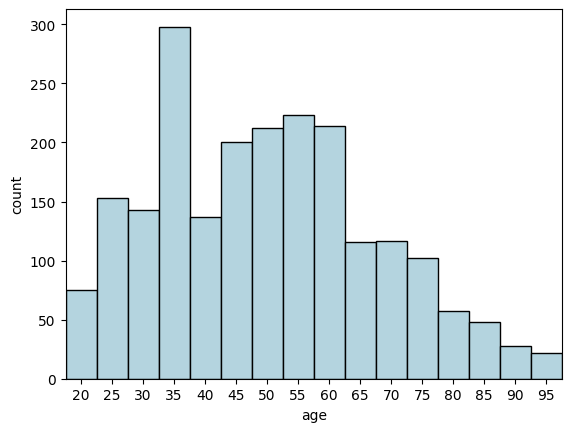

In [47]:
# we'll filter the fraudulent transactions
fraud = rdf.filter(pl.col("is_fraud") == True)

# we use the histplot function to plot the data
fraud.histplot(x="age", bins=5)

The graph shows us that clients between the ages of 30 and 55 are the most frequent victims of fraud. But knowing that doesn't really get us anywhere. We're missing context, so we'll now map out the likelihood of a transaction being fraudulent, relative to an age group's total transactions.

To do this, we'll create a new column called `age range`, containing ages rounded down to the nearest multiple of 5. You can do this manually by writing up a custom PyTorch module if you wish to, but we already made one in BastionLab to save you the hassle: `ApplyBins`. You'll have to use it in combination with the `apply_udf` function, which will apply any module, either built-in BastionLab (like `ApplyBins`) or a custom one written by the user, to every cell in a column.  

It's very important to note that this is useful tool, but also a very limited tool for security reasons, because we can't allow random function to be applied to the data. (For example, we decided to not go with `lambda` and `map` and `apply` which are too permissive and could be misused.)

And we're all set up! Let's now plot the `mean` value of `is_fraud`, where values closer to `1` represent a higher ratio of fraudulent transactions. We'll display it using the `barplot` function.

[2023-01-23T13:27:13Z INFO  bastionlab_polars] Succesfully ran query on 14bffe04-4972-438a-add4-6daa8ff055b0


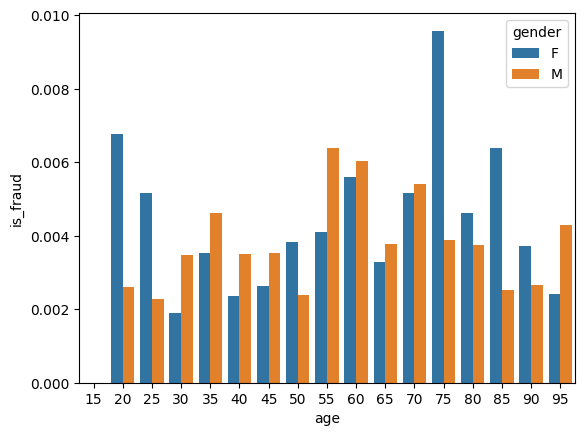

In [48]:
# import ApplyBins module
from bastionlab.polars.utils import ApplyBins

# instantiate ApplyBins with a bins_value of 5
model = ApplyBins(5)

# select columns and apply bins to "age" column
age_comp = rdf.select([pl.col("age"), pl.col("gender"), pl.col("is_fraud")]).apply_udf(
    ["age"], model
)

# get barplot visualization
age_comp.barplot(x="age", y="is_fraud", hue="gender")

This visualization paints a very different picture. 

- We see that women aged 75-80 and 85-90 are particularly at risk of being the victim of fraud as well as women between the ages of 20-25. This could be explained by younger bank users having less life experiences in spotting fraudulent transactions; while older clients may struggle with online banking because they didn't grow up with today's technology.

- We also see that most frauds happen to people aged 30-55. But this age group is highly represented in all overall transactions, non-fraudulent transactions included. This result is to be expected as the 30-55 year old will likely wield a larger spending power, simply because there are less students or retired people in these age categories. Meanwhile, the previously mentioned 20-25 and 75-90 groups are more at risk per transaction. 

Let's dig deeper from there, and get a list of the most at-risk age category across all genders.

We'll group data by `age` (with the groups - *bins* - from the previous query applied) and we'll create two columns: `total` and `fraud`. Total is a `count` of all `is_fraud` values per each group, regardless of if they are True of False. `fraud` is the sum of the `is_fraud` values (`False` values which equal 0 will not be part of the sum).

Next we create a `percentage` column. Then, we select the `age` and `percentage` columns only, and `fetch` this table in descending order.

In [49]:
# group data into age categories
percentage = age_comp.groupby("age").agg(
    [
        # create a fraud column with the total number of fraudulent transactions
        pl.col("is_fraud").sum().alias("fraud"),
        # create a total column with the total number of transactions
        pl.col("is_fraud").count().alias("total"),
    ]
)

# add a percentage column with the percentage of fraudulent transactions
# within the total transactions
percentage = percentage.with_column(
    (pl.col("fraud") / pl.col("total") * 100).alias("percentage")
)

# Select the age and percentage columns and display them in order from
# highest to lowest percentage
percentage.select([pl.col("age"), pl.col("percentage")]).sort(
    pl.col("percentage"), reverse=True
).collect().fetch()

[2023-01-23T13:27:19Z INFO  bastionlab_polars] Succesfully ran query on 972a8505-c77c-4569-a195-e49b959c22c6


shape: (17, 2)
┌─────┬────────────┐
│ age ┆ percentage │
│ --- ┆ ---        │
│ i32 ┆ f64        │
╞═════╪════════════╡
│ 75  ┆ 0.608193   │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 60  ┆ 0.579836   │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 55  ┆ 0.536354   │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 70  ┆ 0.525512   │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ ... ┆ ...        │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 45  ┆ 0.30533    │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 40  ┆ 0.290254   │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 30  ┆ 0.26703    │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 15  ┆ 0.0        │
└─────┴────────────┘

### Focus on time and weekday

The next relationship we will zoom is how time and day effect the likelihood of a fraudulent transaction. To do that, we can draw two different `barplots`. One will show genuine transactions per hour in the day and the other will show fraudulent transactions per hour in the day.

To calculate this, let's group data by hour in the day and get an aggregated count of transactions per each category.

Note that Bastionlab's visualization functions are built upon `matplotlib` functions, so they are compatible with any other [`matplotlib.pyplot`](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) functions. Here, we'll use pyplot's `subplots` function so our two barplots are side-by-side.

[2023-01-23T13:27:22Z INFO  bastionlab_polars] Succesfully ran query on 63fec706-1f2f-442c-a4d1-9dbdf7221414
[2023-01-23T13:27:22Z INFO  bastionlab_polars] Succesfully ran query on e912f80d-b94d-4ae7-8a76-5863c776c638


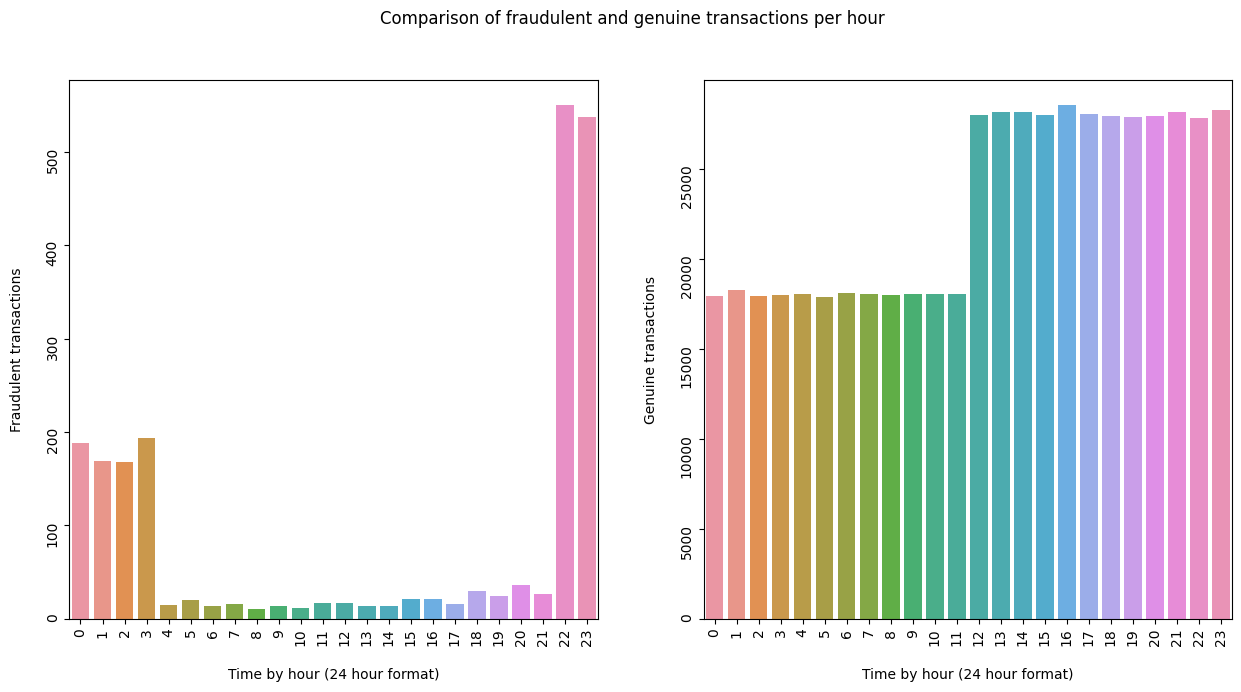

In [50]:
import matplotlib.pyplot as plt

# filtering the non-fraudulent transactions
not_fraud = rdf.filter(pl.col("is_fraud") == False)

# get a subplot with 1 row and 2 columns and set size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# set global title
fig.suptitle("Comparison of fraudulent and genuine transactions per hour")


# group fraudulent transactions by hour and get the total transactions per group
time = fraud.groupby(pl.col("trans_time").dt.hour()).agg(pl.count())

# call barplot- forwarding on our first subplot axes
time.barplot(x="trans_time", y="count", ax=ax1)

# set x and y axes titles and rotate x labels for increased readability
ax1.set_ylabel("Fraudulent transactions\n")
ax1.set_xlabel("\nTime by hour (24 hour format)")
ax1.tick_params(labelrotation=90)

# group genuine transactions by hour and get the total transactions per group
time = (
    not_fraud.groupby(pl.col("trans_time").dt.hour())
    .agg(pl.count())
    .sort(pl.col("trans_time"))
)

# call barplot- forwarding on our second subplot axes
time.barplot(x="trans_time", y="count", ax=ax2)

# set x and y axes titles and rotate x labels
ax2.set_ylabel("Genuine transactions\n")
ax2.set_xlabel("\nTime by hour (24 hour format)")

# set x axis labels and totates X-Axis labels by 90 degrees
ax2.tick_params(labelrotation=90)

# display plots
plt.show()

Interesting: the risk of being a victim to fraud is greatly increased at night between the hours of 10pm-4am. 

This phenomena cannot be explained by general shopping trends in our non-fraudulent data, so next, we will do a similar comparison but we'll focus on the role of the days of the week. Let's use a `lineplot` visualization this time, and show fraud and genuine transactions with different colored lines. 

But first, we'll need to re-scale our data so that we can view trends relative to the overall number of fraudulent or genuine transactions. 

A very soon-to-come version of BastionLab will include a `z_score_scale` method to scale data to numbers between the value of `-1` and `1`. In the meantime, we can implement the scaling manually by using the `with_column` method and applying the formula for z_score scaling: `( x - m ) / s`, where `m` is the mean of `x` and `y` is the std of `x`. 

[2023-01-23T13:27:26Z INFO  bastionlab_polars] Succesfully ran query on 8c68a4b8-5aca-46c3-bd1a-28097e53c5ff
[2023-01-23T13:27:27Z INFO  bastionlab_polars] Succesfully ran query on 2df740ac-b7a0-4769-af44-f7f88071ffc0


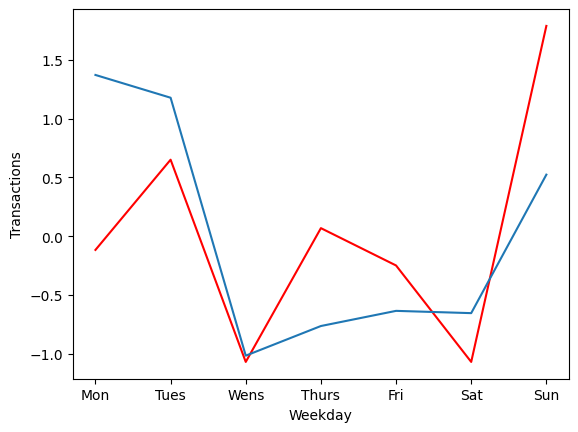

In [51]:
# group fraudulent transactions by hour and get the total transactions per group
week = fraud.groupby(pl.col("trans_date").dt.weekday()).agg(pl.count())

# re-scale data
week = week.with_column(
    (pl.col("count") - pl.col("count").mean()) / pl.col("count").std().alias("count")
)

# draw a lineplot with color set to red
week.lineplot(x="trans_date", y="count", color="red")

# group genuine transactions by hour and get the total transactions per group
week = (
    not_fraud.groupby(pl.col("trans_date").dt.weekday())
    .agg(pl.count())
    .sort(pl.col("trans_date"))
)
# re-scale data
week = week.with_column(
    (pl.col("count") - pl.col("count").mean()) / pl.col("count").std().alias("count")
)

# draw a lineplot with default color (blue)
week.lineplot(x="trans_date", y="count")

plt.xticks(
    ticks=[0, 1, 2, 3, 4, 5, 6],
    labels=["Mon", "Tues", "Wens", "Thurs", "Fri", "Sat", "Sun"],
)
plt.ylabel("Transactions")
plt.xlabel("Weekday")
plt.show()

This graph shows that Thursdays, Fridays and Sundays are associated with a relatively increased risk of fraud for our dataset.

To summarize, we learned that fraudulent transactions are most likely to happen at night. This could reflect that clients are less alert to fraud at night, perhaps because they are more tired. Another notable fact is that more fraudulent transactions seem to take place towards the end of the week. It is harder to infer why, but we could for example imagine that people are also more tired at the end of their working week or are being distracted by preparations for the up-coming working week.

### Focus on category

Next, we will look for any correlations between `category` and fraudulent transactions in our dataset. 

Let's use the `pieplot` method to draw a pie chart representing the weight of the top 10 categories for fraudulent and genuine transactions.

We will again use matplotlib's `subplots` method and relevant functions to display these plots side-by-side.

[2023-01-23T13:27:30Z INFO  bastionlab_polars] Succesfully ran query on 53cc5ced-5eea-4d95-9ed4-e013631e8628
[2023-01-23T13:27:30Z INFO  bastionlab_polars] Succesfully ran query on 0f276bbb-f518-4b6c-b9fe-4da646a6b0a9
[2023-01-23T13:27:30Z INFO  bastionlab_polars] Succesfully ran query on 9a0ef27a-502c-4392-bf4f-969561e224fd
[2023-01-23T13:27:31Z INFO  bastionlab_polars] Succesfully ran query on 4a4e189a-578d-4cb9-bcfe-a9d004189446


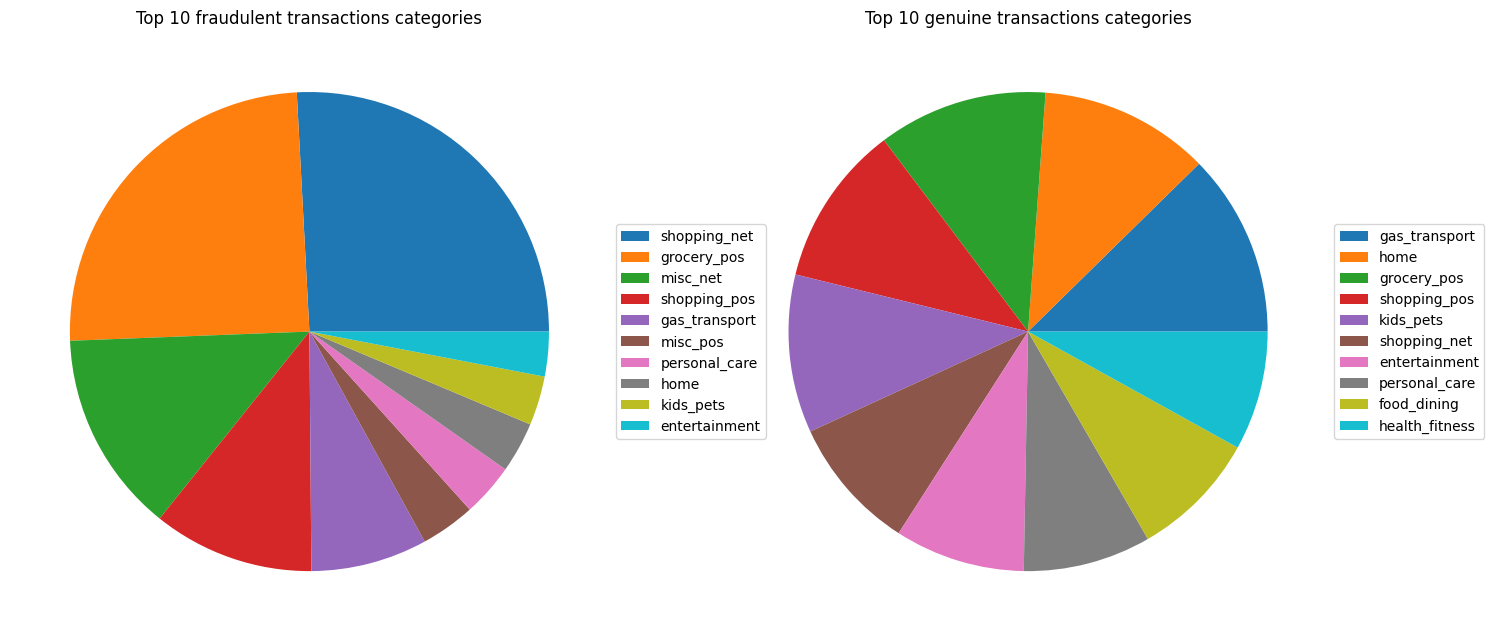

In [52]:
# create subplot grid with 1 row and 2 columns and set size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 10))

# group our fraud dataset by category and count transactions per group
# next we sort the results in descending order and limit our results to the top 10 results
fraud_per_cat = (
    fraud.groupby(pl.col("category"))
    .agg(pl.count())
    .sort(pl.col("count"), reverse=True)
    .limit(10)
)

# Call pieplot and forward on axes for subplot
fraud_per_cat.pieplot(
    labels="category",
    parts="count",
    title="Top 10 fraudulent transactions categories",
    pie_labels=False,
    ax=ax1,
)

# group our non-fraud dataset by category and count transactions per group
# next we sort the results in descending order and limit our results to the top 10 results
not_fraud_per_cat = (
    not_fraud.groupby(pl.col("category"))
    .agg(pl.count())
    .sort(pl.col("count"), reverse=True)
    .limit(10)
)

# Call pieplot and forward on axes for subplot
not_fraud_per_cat.pieplot(
    labels="category",
    parts="count",
    title="Top 10 genuine transactions categories",
    pie_labels=False,
    ax=ax2,
)

This pie chart shows `shopping_net` (online shopping), `grocery_pos` (grocceries point of sale) and `misc_net` (various online purchases), as the most important categories for fraudulent categories, which is not replicated in the non-fraudulent pieplot.

Let's get a better insight and run an additional query to get the percentage of fraudulent transactions per category.

In [53]:
# group data by category
percentage = rdf.groupby("category").agg(
    [
        # create a fraud column with the total number of fraudulent transactions
        pl.col("is_fraud").sum().alias("fraud"),
        # create a total column with the total number of transactions (fraudulent and non-fraudulent)
        pl.col("is_fraud").count().alias("total"),
    ]
)

# add a percentage column with the percentage of fraudulent transactions within the total transactions
percentage = percentage.with_column(
    (pl.col("fraud") / pl.col("total") * 100).alias("percentage")
)

# Select just the category and percentage columns and display in order from highest to lowest percentage
percentage.select([pl.col("category"), pl.col("percentage")]).sort(
    pl.col("percentage"), reverse=True
).collect().fetch()

[2023-01-23T13:27:35Z INFO  bastionlab_polars] Succesfully ran query on 06964d39-072e-4f0f-b8c3-199ef6a8d6a1


shape: (14, 2)
┌────────────────┬────────────┐
│ category       ┆ percentage │
│ ---            ┆ ---        │
│ str            ┆ f64        │
╞════════════════╪════════════╡
│ shopping_net   ┆ 1.211135   │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ misc_net       ┆ 0.975628   │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ grocery_pos    ┆ 0.922878   │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ shopping_pos   ┆ 0.427788   │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ ...            ┆ ...        │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ health_fitness ┆ 0.14179    │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ food_dining    ┆ 0.137517   │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ kids_pets      ┆ 0.133492   │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ home           ┆ 0.127999   │
└────────────────┴────────────┘

To summarize, we note an additional risk of fraudulent transactions with online purchases, with online shopping and various online purchases as the two most important categories of fraudulent transactions. 

### Conclusions

This brings us to the end of our data exploration. We gained meaningful insights: 

- 75-80 year old women are the most at risk age/sex group in the dataset, while 35-40 year olds are the most frequent victims of fraud.

- There is a much higher risk of fraud at night.

- The online shopping, grocceries point of sale purchases and various online purchases are the categories most highly correlated with fraudulent transactions.

We are done for the day: we can close our connection and stop the server!

In [54]:
# connection.close()
# bastionlab_server.stop(srv)

Stopping BastionLab's server...


True